# Kuramoto Model For Prediction in Uncinate Circuit
Author: Rohit Konda

## Introduction

### Major Depressive Disorder (MDD) and Deep Brain Stimulation (DBS)

Major depressive disorder (MDD) is a mood disorder characterized by disturbances to emotional regulation, decreased cognitive functions, disturbed sleep cycle, and suicidal ideations.MDD is one of the most widely prevalent clinical disorders, with almost 5% of the general population meet the standards for MDD. There are various risk factors for MDD, including genetics, personality traits, and traumatic experiences.<sup>[1]</sup>

The normal courses of treatment for MDD include psychotherapy, drug medications, and electroconvulsive therapy. However, there are still some cases of treatment-resistant depression. Deep brain stimulation, especially in the subcallosal cingulate (SCC) region, has been shown to high efficacy to return patients back to their normal state. Direct implantation of active electrodes in the SCC region has been shown to reduce local cortical blood flow, and reduce depression symptoms. Despite the shown effectiveness of this treatment, there is little knowledge on the mechanism behind this treatment.<sup>[2,3]</sup>

### Network Oscillatory Activity

Abnormal neural network activity is suspected to be the underlying cause of MDD. Measuring local field potentials (LFP) using various electrophysiology measures, such as EEG, we can find coherence measures to quantify how MDD affects certain brain networks. Using dynamic casual modeling to find the best-fit model, we can infer information about the relations in connectivity between network activity, and optimize certain parameters for DBS.<sup>[4]</sup>

### Kuramoto Model

The basic model used for characterizing the system is the Kuramoto model, first developed by Yoshiki Kuramoto. The Kuramoto model has been used to describe various network oscillation paradigms, including organism population and environmental dynamics. The Kuramoto model is also robust in characterizing the coupling between oscillations in different brain regions. <sup>[5]</sup> 



In [2]:
%reset
%matplotlib inline
import networkx as nx
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import cmath as c

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Exploring the Kuramoto Model

### Structure
The underlying structure of a basic Kuramoto model is: $
\begin{equation}
\dot{\phi_i} = \omega_i + \frac{K}{N} \sum\limits_{j \in N_i} f(\phi_j - \phi_i)
\end{equation}
$, where phase corresponds to the progress of an action potential, K is the coupling constant between nodes, omega is the intrinsic speed of firing for a node, and f is the function of coupling, which is usually sin or cos.
Using the graphical formulation of the Kuramoto Model, we get:  
$
\begin{equation}
\dot{\vec{\phi}} = \vec{\omega} + D f( D^T \vec{\phi})
\end{equation}
$, where D is an oriented incidence matrix of the graph. This modified version is presented in \cite{}

### SCC Network

The network consists of 6 nodes, corresponding to different brain regions in the SCC, and the edges representing different white matter tracts between them. 

### Approximation of the Behavior

Euler's approximation and Runge-Kutta's approximation was employed to sufficiently approximate the behavior of the network.

### Getting more complex behavior

For simulating different conductances between different brain regions, a diagonal weight matrix was multiplied to the incidence matrix.

For simulating different coherences between regions, different functions were applied to each row of the incidence matrix.

For simulating range of coherences between tracts, a linear combination of sin and cos was applied to be directly formulating from coherence:
$
\begin{equation}
Asin(x) + Bcos(x) = \sqrt{A^2 + B^2}sin(arctan(A/B))
\end{equation}
$

$
\begin{equation}
A + B = 1
\end{equation}
$

$
\begin{equation}
A = coherence, B = 1 - coherence
\end{equation}
$


In [3]:
class KModel:
    def __init__(self, A, K = 1, dt = .05, coh = [1]*8):
        #Graph representation of network
        self.G = nx.from_numpy_matrix(A) #Graph
        self.states = np.matrix([4,1,3,5,6,2]).T #np.matrix(np.random.uniform(0,2*np.pi,size=(6,1)))# memory of phases
        self.w = np.matrix([3.0,3.3,3.6,3.9,4.2,4.5]).T#np.matrix(np.random.normal(3,.2,size=(6,1))) #init intrinsic freq.
        self.K = K #Coupling constant
        self.coh = coh #measures of coherence between each edge
        self.t = 0 #time
        self.dt = dt #time step
    
    #Kuramoto differential equation
    def phase_dev(self,phase):
        D = (nx.incidence_matrix(self.G, oriented = True, weight = 'weight')).todense() #incidence
        N = np.random.normal(0, 10, [len(D[0]), 1])
        return self.w - self.K / len(self.G) * D * -self.edge_func(D.T * self.states[:,-1]) #+N
    
    #euler method approximation of behavior
    def euler_step(self):
        new_state = self.states[:,-1] + self.phase_dev(self.states[:,-1])*self.dt
        new_state = new_state % (2 * np.pi)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))
       
    #runge-Kutta approximation of behavior
    def runge_kutta_step(self):
        k1 = self.phase_dev(self.states[:,-1])*self.dt
        k2 = self.phase_dev(self.states[:,-1]+ .5*k1)*self.dt
        k3 = self.phase_dev(self.states[:,-1]+ .5*k2)*self.dt
        k4 = self.phase_dev(self.states[:,-1]+ k3)*self.dt
        new_state = self.states[:,-1] + (k1+ 2*k2 + 2*k3 + k4)/6
        new_state = new_state % (2 * np.pi)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))
    
    #time step function
    def step(self):
        self.euler_step()
    
    #coherence function
    def coh_func(self,coh,x):
        c1 = 1 - coh
        c2 = coh
        A = np.sqrt(c1**2+c2**2)
        if coh == 0:
            offset = np.pi/2
        else:
            offset = np.arctan(c1/c2)
        return A*np.sin(x+offset)
    
    #applying function to phase difference for each edge 
    def edge_func(self,M):
        e = [self.coh_func(self.coh[i],M.tolist()[i])[0] for i in range(0,len(self.coh))]
        return np.matrix(e).T   

[[0. 1. 1. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 1. 0.]]


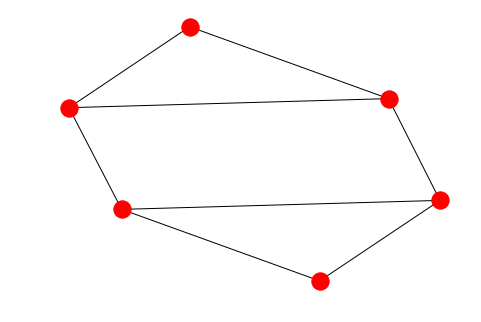

In [4]:
nodes = [1,2,3,4,5,6]
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from([(1,2,1),(2,3,1),(1,6,1),(1,3,1),(3,4,1),(4,5,1),(4,6,1),(5,6,1)])


#Quick plot of G
nx.draw(G)
A = nx.to_numpy_matrix(G)
print(A)

#### Runs specified kuramoto model for a given amount of time, default is 10 sec.

In [5]:
def run_model(A, K = 10, t = 10):
    P = KModel(A, K)
    for ts in range(0,int(t/P.dt)):
        P.step()
    return P

#### Displays states of each node over a certain time interval, default is 10 sec.

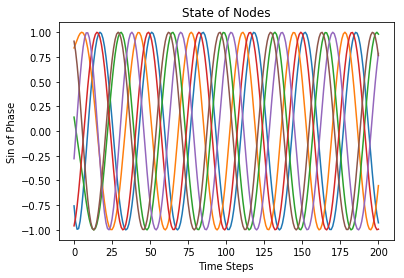

In [6]:
def state_course(states):
    plt.figure()
    plt.plot(np.sin(states.T))
    plt.xlabel('Time Steps')
    plt.ylabel('Sin of Phase')
    plt.title('State of Nodes')
    plt.show()
state_course(run_model(A).states)
def R_course(states):
    Var = []
    for x in np.array(states.T):
        z = [c.exp(complex(0,phase)) for phase in x]
        z = sum(z)/len(z)
        Var.append(1-abs(z))
    plt.figure()
    plt.plot(Var)
    plt.xlabel('Time Steps')
    plt.ylabel('Variance')
    plt.title('Variance State')
    plt.show()
#R_course(run_model(A).states)


#### A visual representation of the network graph.

#### A polar representation of the different current phases of the kuramoto model.

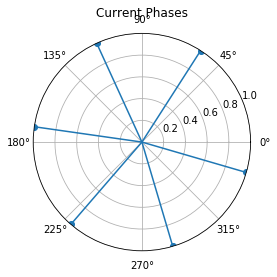

In [7]:
K = KModel(A)
def phaseplot(K):   
    plt.figure()
    ax = plt.subplot(111,projection='polar')
    ax.stem(K.states[:,-1],np.ones(K.states[:,-1].shape))
    ax.set_title('Current Phases')
    ax.set_rmax(1)
    plt.show()
phaseplot(K)

#### An animation of the kuramoto model, in real time.

<IPython.core.display.Javascript object>


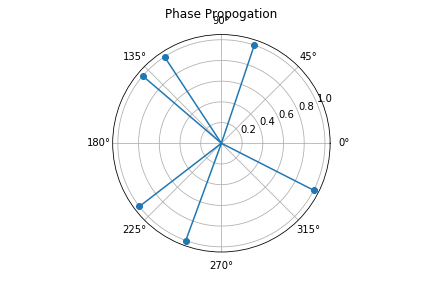

In [15]:
K = KModel(A)
def animate(K,t):
    %matplotlib notebook
    import time
    import pylab as plt
    t_full = t
    radii = np.ones(K.states[:,-1].shape)
    
    fig,ax = plt.subplots(1, 1, subplot_kw=dict(polar=True))
    ax.set_rmax(10)
    ax.set_title('Phase Propogation')
    for i in range(0,int(t_full/K.dt)):
        K.step()
        ax.lines = []
        ax.stem(K.states[:,-1],radii)
        fig.canvas.draw()
        if(K.dt > .06):
            time.sleep(K.dt-.06)
animate(K,10)
%matplotlib inline

In [9]:
def R_sweep(A, Ki = 0, Kf = 10, N = 10):
    def calcR(P):
        Var = []
        for x in np.array(P.states.T):
            z = [c.exp(complex(0,phase)) for phase in x]
            z = sum(z)/len(z)
            Var.append(1-abs(z))
        return sum(Var[round(len(Var)/2):-1])/len(Var)
    KVar = []
    KSpan = np.linspace(Ki,Kf, num = N)
    for K in KSpan:
        P = run_model(A,K,t = 10)
        KVar.append(calcR(P))
    plt.figure()
    plt.plot(KSpan,KVar)
    plt.xlabel('K values')
    plt.ylabel('Mean Variance over 10s')
    plt.title('Global Variance vs K')
    plt.show()
    return (KSpan, KVar)
def edge_R_sweep(A, Ki = 0, Kf = 10, N = 10):
    def calc_edgeR(P):
        Var = []
        for x in np.array(P.states.T):
            z = [c.exp(complex(0,phase)) for phase in x]
            edgeR = [abs(z[a] - z[b]) for (a,b) in P.G.edges()]
            Var.append(edgeR)
        Var = Var[round(len(Var)/2):-1]
        return [ sum(x)/len(Var) for x in zip(*Var)]
    KVar = []
    KSpan = np.linspace(Ki,Kf, num = N)
    for K in KSpan:
        P = run_model(A,K,t = 10)
        KVar.append(calc_edgeR(P))
    plt.figure()
    plt.plot(KVar)
    plt.xlabel('K values')
    plt.ylabel('Mean Variance over last 5s')
    plt.title('Edge Variance vs K')
    plt.show()
    return (KSpan, KVar)

#### A spectogram of the kuramoto for a given time and sampling rate, default is 10 sec, and 1000 Hz respectively.

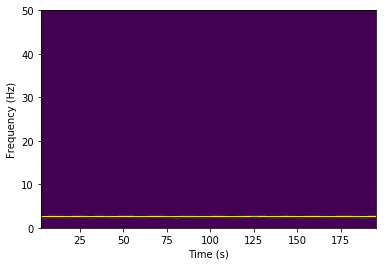

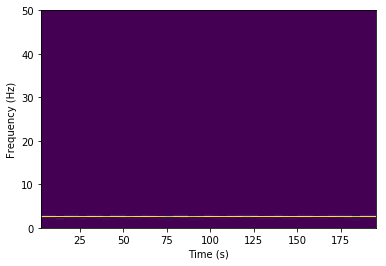

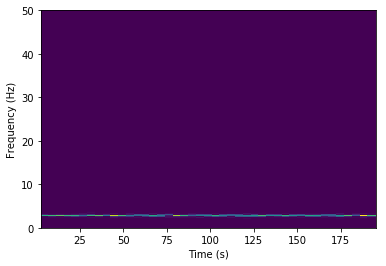

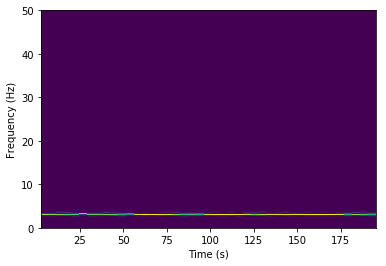

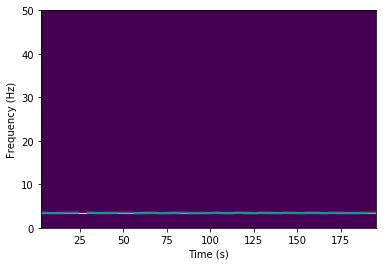

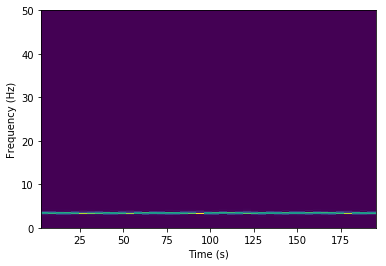

In [10]:
def K_spectogram(K, t = 1000, sr = 100):
    model = run_model(A, K, t)
    for i in range(0,model.states.shape[0]):
        f, t, s = sig.spectrogram(10*np.sin(np.array(model.states[i,:])[0]), sr, nperseg = 512, nfft = 2**9)  ###
        plt.pcolormesh(t, f, s)
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.show()
    
K_spectogram(1)

#### Create a multinode network

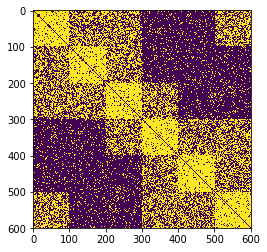

In [11]:
def make_bigger_matrix(A, side, large = .9, medium = .5, small = .1):
    B = [1]*(len(A)*side)
    i = 0
    for r in A.tolist():
        row = [[]]*side
        j = 0
        for c in r:
            if c > 0:
                cluster = [[1 if col < medium else 0 for col in row] for row in np.random.rand(side,side)]
            elif j == i:
                cluster = [[1 if col < large else 0 for col in row] for row in np.random.rand(side,side)]
            else:
                cluster = [[1 if col < small else 0 for col in row] for row in np.random.rand(side,side)]
            row = np.hstack((row,cluster))
            j += 1
        B = np.vstack((B,row))
        i += 1
    B = B[1:][:]
    for i in range(len(B)):
                B[i][i] = 0
                for j in range(i):
                    B[i][j] = B[j][i]
    return B
A = nx.to_numpy_matrix(G)
B = make_bigger_matrix(A, 100)
plt.figure()
plt.imshow(B, interpolation="nearest")

#Use B when initializing matrix

In [12]:
'''
class SLModel:
    def __init__(self, A, K = 1, dt = .05):
        #Graph representation of network
        self.G = nx.from_numpy_matrix(A) #Graph
        self.states = np.matrix([4,1,3,5,6,2]).T #np.matrix(np.random.uniform(0,2*np.pi,size=(6,1)))# memory of phases
        self.w = np.matrix([3.0,3.3,3.6,3.9,4.2,4.5]).T#np.matrix(np.random.normal(3,.2,size=(6,1))) #init intrinsic freq.
        self.p = 1 #radius of oscialltion, Hopf bifurcation parameter
        self.aj = [1,1,1,1,1,1]
        self.Bi = [1,1,1,1,1,1]
        self.K = K #Coupling constant
        self.t = 0 #time
        self.dt = dt #time step
    
    #Kuramoto differential equation
    def phase_dev(self,phase):
        N = np.random.normal(0, 10, [6, 1])
        
        p = np.matrix([self.p**2 for i in range(6)]).T
        z2 = np.matrix([abs(z)**2 for z in self.states[:,-1].T.tolist()[0]]).T
        limitcycle = np.multiply((1j * self.w + p - z2),self.states[:,-1])
        
        #dipole = sum(np.multiply(np.real(self.states[:,-1].tolist()[0]),self.aj))
        #stim = dipole * np.matrix(self.Bi).T

        D = (nx.incidence_matrix(self.G, oriented = True, weight = 'weight')).todense() #incidence
        coupling = self.K * D * D.T * self.states[:,-1]
    
        return limitcycle + coupling #+ stim  + N

    #euler method approximation of behavior
    def euler_step(self):
        new_state = self.states[:,-1] + self.phase_dev(self.states[:,-1])*self.dt
        print(new_state)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))
       
    #runge-Kutta approximation of behavior
    def runge_kutta_step(self):
        k1 = self.phase_dev(self.states[:,-1])*self.dt
        k2 = self.phase_dev(self.states[:,-1]+ .5*k1)*self.dt
        k3 = self.phase_dev(self.states[:,-1]+ .5*k2)*self.dt
        k4 = self.phase_dev(self.states[:,-1]+ k3)*self.dt
        new_state = self.states[:,-1] + (k1+ 2*k2 + 2*k3 + k4)/6
        new_state = new_state % (2 * np.pi)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))
    
    #time step function
    def step(self):
        self.euler_step()  

def run_model(A, K = 10, t = 10):
    SL = SLModel(A, K)
    for ts in range(0,int(t/SL.dt)):
        SL.step()
    return SL
run_model(A)
'''

"\nclass SLModel:\n    def __init__(self, A, K = 1, dt = .05):\n        #Graph representation of network\n        self.G = nx.from_numpy_matrix(A) #Graph\n        self.states = np.matrix([4,1,3,5,6,2]).T #np.matrix(np.random.uniform(0,2*np.pi,size=(6,1)))# memory of phases\n        self.w = np.matrix([3.0,3.3,3.6,3.9,4.2,4.5]).T#np.matrix(np.random.normal(3,.2,size=(6,1))) #init intrinsic freq.\n        self.p = 1 #radius of oscialltion, Hopf bifurcation parameter\n        self.aj = [1,1,1,1,1,1]\n        self.Bi = [1,1,1,1,1,1]\n        self.K = K #Coupling constant\n        self.t = 0 #time\n        self.dt = dt #time step\n    \n    #Kuramoto differential equation\n    def phase_dev(self,phase):\n        N = np.random.normal(0, 10, [6, 1])\n        \n        p = np.matrix([self.p**2 for i in range(6)]).T\n        z2 = np.matrix([abs(z)**2 for z in self.states[:,-1].T.tolist()[0]]).T\n        limitcycle = np.multiply((1j * self.w + p - z2),self.states[:,-1])\n        \n        #dipol

# References
<i>
[1]  Fava, M., & Kendler, K. S. (2000). Major Depressive disorder. Neuron, 28(2), 335–341. doi:10.1016/s0896-6273(00)00112-4 <br><br>
[2] Mayberg, H. S., Lozano, A. M., Voon, V., McNeely, H. E., Seminowicz, D., Hamani, C., … Kennedy, S. H. (2005). Deep brain stimulation for treatment-resistant depression. Neuron, 45(5), 651–660. doi:10.1016/j.neuron.2005.02.014 <br><br>
[3] Riva-Posse, P., Choi, K. S., Holtzheimer, P. E., McIntyre, C. C., Gross, R. E., Chaturvedi, A., … Mayberg, H. S. (2014). Defining critical white matter pathways mediating successful Subcallosal Cingulate deep brain stimulation for treatment-resistant depression. Biological Psychiatry, 76(12), 963–969. doi:10.1016/j.biopsych.2014.03.029 <br><br>
[4] Einevoll, G. T., Kayser, C., Logothetis, N. K., & Panzeri, S. (2013). Modelling and analysis of local field potentials for studying the function of cortical circuits. Nature Reviews Neuroscience, 14(11), 770–785. doi:10.1038/nrn3599 <br><br>
[5] Rodrigues, F. A., Peron, T. K. Dm., Ji, P., & Kurths, J. (2016). The Kuramoto model in complex networks. Physics Reports, 610, 1–98. doi:10.1016/j.physrep.2015.10.008 <br><br>
[6] Breakspear, Research, M. H., Brisbane, R., Hospital, W., Services, M. H., Institute, T. B. D., … Wales, N. S. (2010). Generative models of cortical Oscillations: Neurobiological implications of the Kuramoto model. Frontiers in Human Neuroscience, 4, . doi:10.3389/fnhum.2010.00190 <br><br>
[7] Cumin, D., & Unsworth, C. P. (2007). Generalising the Kuramoto model for the study of neuronal synchronisation in the brain. Physica D: Nonlinear Phenomena, 226(2), 181–196. doi:10.1016/j.physd.2006.12.004 <br><br>
[8] Jadbabaie, A., Motee, N., & Barahona, M. (2005). On the Stability of the Kuramoto Model of Coupled Nonlinear Oscillators. 2004 American Control Conference <br><br>
[9] Ibáñez-Molina, A. J., & Iglesias-Parro, S. (2016). Neurocomputational model of EEG complexity during mind wandering. Frontiers in Computational Neuroscience, 10, . doi:10.3389/fncom.2016.00020 <br><br>


[10] Xu, Z, & Egerstedt, M. & Droge, G. &, Schiling, K. (2013). Balanced Deployment of Multiple Robots Using a Modified Kuramoto Model. American Control Conference <br><br>
</i>